<a href="https://colab.research.google.com/github/geexe/cat-facial-expression-recognition/blob/main/Cat_Facial_Expression_Recognition_2024-08-05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### START HERE!

---



In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Aug  5 03:38:25 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0              52W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

# Setup

In [53]:
!pip install tensorflow albumentations opencv-python
!pip install pandas opencv-python

In [54]:
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
# Clone the repository
!git clone https://github.com/kkengg/cat-facial-expression-recognition

Cloning into 'cat-facial-expression-recognition'...
remote: Enumerating objects: 5639, done.
remote: Counting objects: 100% (346/346), done.
remote: Compressing objects: 100% (171/171), done.
remote: Total 5639 (delta 327), reused 175 (delta 175), pack-reused 5293
Receiving objects: 100% (5639/5639), 1.38 GiB | 31.92 MiB/s, done.
Resolving deltas: 100% (479/479), done.
Updating files: 100% (4606/4606), done.


#Load CatFLW Data with JSON Annotations

In [122]:
import numpy as np
import cv2
import os
import glob
import json

images = []
bboxes = []
labels = []

imgs_list = sorted(glob.glob('/content/cat-facial-expression-recognition/CatFLW dataset/images/*.png'))

for i in range(len(imgs_list)):
    name = imgs_list[i].split('/')[-1][:-4]
    # Read the image
    image = cv2.imread(f'/content/cat-facial-expression-recognition/CatFLW dataset/images/{name}.png')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(np.asarray(image))

    # Read the labels and bounding boxes from JSON
    with open(f'/content/cat-facial-expression-recognition/CatFLW dataset/labels/{name}.json', 'r') as f:
        data = json.load(f)
        labels.append(data['labels'])
        bboxes.append(data['bounding_boxes'])

bboxes = np.array(bboxes)
labels = np.array(labels)

print(len(images), bboxes.shape, labels.shape)

2079 (2079, 4) (2079, 48, 2)


In [121]:
# Not run
'''
import os
import json
import pandas as pd

# Define directories
image_dir = '/content/cat-facial-expression-recognition/CatFLW dataset/images/'
json_dir = '/content/cat-facial-expression-recognition/CatFLW dataset/labels/'

# Get list of image files
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

# Initialize list to store data
data = []

# Loop through each image file
for image_file in image_files:
    # Construct file paths
    image_path = os.path.join(image_dir, image_file)
    json_path = os.path.join(json_dir, image_file.replace('.png', '.json'))  # Assuming image files are .jpg

    # Read the JSON file
    if os.path.exists(json_path):
        with open(json_path, 'r') as f:
            json_data = json.load(f)

        # Extract coordinates and bounding box
        coordinates = json_data['labels']
        bounding_box = json_data['bounding_boxes']

        # Extract bounding box dimensions
        x_min, y_min, x_max, y_max = bounding_box
        box_width = x_max - x_min
        box_height = y_max - y_min

        # Normalize coordinates
        normalized_coords = []
        for (x, y) in coordinates:
            normalized_x = (x - x_min) / box_width
            normalized_y = (y - y_min) / box_height
            normalized_coords.append(normalized_x)
            normalized_coords.append(normalized_y)

        # Add data to the list
        data.append([image_file, image_path] + normalized_coords)

# Create DataFrame
column_names = ['image_file', 'file_path'] + [f'x{i//2+1}' if i % 2 == 0 else f'y{i//2+1}' for i in range(2 * len(coordinates))]
df = pd.DataFrame(data, columns=column_names)

# Save DataFrame to CSV
df.to_csv('coordinates_dataframe_normalized.csv', index=False)

print("DataFrame created and saved to 'coordinates_dataframe_normalized.csv'")
'''

DataFrame created and saved to 'coordinates_dataframe_normalized.csv'


In [123]:
import os
import json
import pandas as pd

# Define directories
image_dir = '/content/cat-facial-expression-recognition/CatFLW dataset/images/'
json_dir = '/content/cat-facial-expression-recognition/CatFLW dataset/labels/'
class_file = '/content/CatFLW-binary.csv'  # Update this path to the location of your class labels CSV file

# Get list of image files
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

# Initialize list to store data
data = []

# Loop through each image file
for image_file in image_files:
    # Construct file paths
    image_path = os.path.join(image_dir, image_file)
    json_path = os.path.join(json_dir, image_file.replace('.png', '.json'))  # Assuming image files are .jpg

    # Read the JSON file
    if os.path.exists(json_path):
        with open(json_path, 'r') as f:
            json_data = json.load(f)

        # Extract coordinates and bounding box
        coordinates = json_data['labels']
        bounding_box = json_data['bounding_boxes']

        # Extract bounding box dimensions
        x_min, y_min, x_max, y_max = bounding_box
        box_width = x_max - x_min
        box_height = y_max - y_min

        # Normalize coordinates
        normalized_coords = []
        for (x, y) in coordinates:
            normalized_x = (x - x_min) / box_width
            normalized_y = (y - y_min) / box_height
            normalized_coords.append(normalized_x)
            normalized_coords.append(normalized_y)

        # Add data to the list
        data.append([image_file, image_path, bounding_box] + normalized_coords)

# Create DataFrame
column_names = ['image_file', 'file_path', 'bounding_box'] + [f'x{i//2+1}' if i % 2 == 0 else f'y{i//2+1}' for i in range(2 * len(coordinates))]
df = pd.DataFrame(data, columns=column_names)

# Load the class CSV file
class_df = pd.read_csv(class_file)

# Merge the DataFrame with the class DataFrame
merged_df = df.merge(class_df, on='image_file')

# Drop rows that do not match
filtered_df = merged_df.dropna()

In [117]:
filtered_df

image_file                                          file_path  \
0    00000352_014.png  /content/cat-facial-expression-recognition/Cat...   
1    00000345_027.png  /content/cat-facial-expression-recognition/Cat...   
2    00000033_022.png  /content/cat-facial-expression-recognition/Cat...   
3    00000421_008.png  /content/cat-facial-expression-recognition/Cat...   
4    00000009_004.png  /content/cat-facial-expression-recognition/Cat...   
..                ...                                                ...   
132  00000049_026.png  /content/cat-facial-expression-recognition/Cat...   
133  00000026_020.png  /content/cat-facial-expression-recognition/Cat...   
134  00000025_029.png  /content/cat-facial-expression-recognition/Cat...   
135  00000012_010.png  /content/cat-facial-expression-recognition/Cat...   
136  00000017_019.png  /content/cat-facial-expression-recognition/Cat...   

                     bounding_box        x1        y1        x2        y2  \
0     [279.0, 98.0, 376.0, 200.0]  0.478536  0.820343  0.623948  0.592402   
1     [310.0, 78.0, 446.0, 215.0]  0.322456  0.870482  0.530118  0.661190   
2       [67.0, 0.0, 673.0, 607.0]  0.293083  0.830465  0.505799  0.635209   
3      [87.0, 31.0, 296.0, 244.0]  0.716124  0.870662  0.767426  0.612310   
4    [323.0, 152.0, 634.0, 460.0]  0.452498  0.908789  0.602762  0.651575   
..                            ...       ...       ...       ...       ...   
132   [192.0, 0.0, 1018.0, 764.0]  0.346494  0.773069  0.574407  0.532589   
133   [209.0, 40.0, 546.0, 370.0]  0.641588  0.774597  0.722027  0.543097   
134   [342.0, 43.0, 481.0, 169.0]  0.453288  0.870214  0.603683  0.637444   
135    [84.0, 70.0, 294.0, 268.0]  0.527929  0.826212  0.637962  0.616985   
136    [63.0, 49.0, 239.0, 213.0]  0.566688  0.847348  0.663966  0.583598   

           x3        y3        x4  ...       y44       x45       y45  \
0    0.481113  0.850167  0.328196  ...  0.733941  0.449979  0.744775   
1    0.315882  0.892088  0.248066  ...  0.806467  0.311757  0.814672   
2    0.279342  0.859063  0.217754  ...  0.783633  0.276333  0.766468   
3    0.720134  0.880873  0.515876  ...  0.775737  0.678163  0.838779   
4    0.456736  0.922977  0.319852  ...  0.820909  0.411733  0.853607   
..        ...       ...       ...  ...       ...       ...       ...   
132  0.342798  0.808284  0.244358  ...  0.689069  0.321281  0.663401   
133  0.636576  0.807848  0.419774  ...  0.669355  0.626739  0.665897   
134  0.454187  0.887532  0.316065  ...  0.791563  0.426906  0.825270   
135  0.528790  0.857025  0.386281  ...  0.760247  0.502548  0.786035   
136  0.567273  0.861128  0.396795  ...  0.753091  0.534420  0.798238   

          x46       y46       x47       y47       x48       y48      Class  
0    0.513546  0.748039  0.314237  0.786441  0.610629  0.791343    Relaxed  
1    0.358971  0.824781  0.193610  0.807547  0.472926  0.866117    Relaxed  
2    0.341406  0.793502  0.119348  0.743562  0.413195  0.854802    Relaxed  
3    0.712699  0.829286  0.589684  0.895549  0.834919  0.810859  Attentive  
4    0.458537  0.844640  0.345768  0.877705  0.624891  0.869987  Attentive  
..        ...       ...       ...       ...       ...       ...        ...  
132  0.382590  0.675166  0.187944  0.728965  0.515667  0.780384    Relaxed  
133  0.677677  0.661967  0.455404  0.802561  0.748407  0.783924  Attentive  
134  0.475885  0.826905  0.325374  0.868198  0.600784  0.868556    Relaxed  
135  0.556910  0.788692  0.420500  0.826086  0.639971  0.801747  Attentive  
136  0.589216  0.789409  0.450494  0.844573  0.681153  0.805012    Relaxed  

[137 rows x 100 columns]

In [124]:
# Create landmark vectors

regions = {
    'left_eye': {'Center': [37, 38], 'Members': [4, 5, 6, 7, 8, 37, 38, 39]},
    'right_eye': {'Center': [40, 41], 'Members': [2, 9, 10, 11, 12, 40, 41, 42]},
    'forehead': {'Center': [23, 32], 'Members': [23, 24, 25, 26, 27, 28, 29, 30, 31, 32]},
    'mouth': {'Center': [17], 'Members': [1, 3, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 33, 34, 35, 36, 43, 44, 45, 46, 47, 48]}
}

# Function to calculate midpoint
def calculate_midpoint(coords, indices):
    x_coords = [coords[f'x{i}'] for i in indices]
    y_coords = [coords[f'y{i}'] for i in indices]
    midpoint_x = np.mean(x_coords)
    midpoint_y = np.mean(y_coords)
    return midpoint_x, midpoint_y

# Create vectors for each region
vector_data = []

for index, row in filtered_df.iterrows():
    image_file = row['image_file']
    file_path = row['file_path']
    classes = row['Class']
    bounding_box = row['bounding_box']
    coords = {f'x{i+1}': row[f'x{i+1}'] for i in range(len(coordinates))}
    coords.update({f'y{i+1}': row[f'y{i+1}'] for i in range(len(coordinates))})

    vector_row = [image_file, file_path, classes, bounding_box]

    for region, points in regions.items():
        center_indices = points['Center']
        member_indices = points['Members']

        # Calculate midpoint for the center points
        midpoint_x, midpoint_y = calculate_midpoint(coords, center_indices)

        # Calculate vectors for each member point
        for i in member_indices:
            member_x = row[f'x{i}']
            member_y = row[f'y{i}']
            vector_x = member_x - midpoint_x
            vector_y = member_y - midpoint_y
            vector_row.extend([vector_x, vector_y])

    vector_data.append(vector_row)

# Create column names for the new DataFrame with vectors
vector_column_names = ['image_file', 'file_path', 'Class','bounding_box'] + [f'{region}_point_{i+1}_x' for region in regions for i in regions[region]['Members']] + [f'{region}_point_{i+1}_y' for region in regions for i in regions[region]['Members']]

# Create the DataFrame with vectors
vector_df = pd.DataFrame(vector_data, columns=vector_column_names)


In [125]:
vector_df

image_file                                          file_path  \
0    00000352_014.png  /content/cat-facial-expression-recognition/Cat...   
1    00000345_027.png  /content/cat-facial-expression-recognition/Cat...   
2    00000033_022.png  /content/cat-facial-expression-recognition/Cat...   
3    00000421_008.png  /content/cat-facial-expression-recognition/Cat...   
4    00000009_004.png  /content/cat-facial-expression-recognition/Cat...   
..                ...                                                ...   
132  00000049_026.png  /content/cat-facial-expression-recognition/Cat...   
133  00000026_020.png  /content/cat-facial-expression-recognition/Cat...   
134  00000025_029.png  /content/cat-facial-expression-recognition/Cat...   
135  00000012_010.png  /content/cat-facial-expression-recognition/Cat...   
136  00000017_019.png  /content/cat-facial-expression-recognition/Cat...   

         Class                  bounding_box  left_eye_point_5_x  \
0      Relaxed   [279.0, 98.0, 376.0, 200.0]            0.003010   
1      Relaxed   [310.0, 78.0, 446.0, 215.0]           -0.010103   
2      Relaxed     [67.0, 0.0, 673.0, 607.0]           -0.012821   
3    Attentive    [87.0, 31.0, 296.0, 244.0]            0.007189   
4    Attentive  [323.0, 152.0, 634.0, 460.0]            0.002846   
..         ...                           ...                 ...   
132    Relaxed   [192.0, 0.0, 1018.0, 764.0]           -0.004880   
133  Attentive   [209.0, 40.0, 546.0, 370.0]           -0.003056   
134    Relaxed   [342.0, 43.0, 481.0, 169.0]           -0.005295   
135  Attentive    [84.0, 70.0, 294.0, 268.0]           -0.001521   
136    Relaxed    [63.0, 49.0, 239.0, 213.0]            0.003920   

     left_eye_point_6_x  left_eye_point_7_x  left_eye_point_8_x  \
0              0.023181           -0.056268           -0.021750   
1              0.008325           -0.039926           -0.040449   
2              0.024341           -0.041687           -0.040964   
3              0.018054           -0.079376            0.005669   
4              0.028396           -0.054225           -0.004445   
..                  ...                 ...                 ...   
132            0.028607           -0.054571           -0.030903   
133            0.028056           -0.075941           -0.015059   
134            0.014710           -0.047094           -0.021933   
135            0.020715           -0.056174           -0.007952   
136            0.013631           -0.054898           -0.000808   

     left_eye_point_9_x  left_eye_point_38_x  ...  mouth_point_34_y  \
0              0.066588             0.028907  ...          0.101588   
1              0.041662             0.030288  ...          0.136360   
2              0.058463             0.049649  ...          0.117550   
3              0.064940            -0.003002  ...          0.070435   
4              0.052164             0.008146  ...          0.094376   
..                  ...                  ...  ...               ...   
132            0.055240             0.037465  ...          0.141932   
133            0.082226             0.033253  ...          0.086059   
134            0.056482             0.025107  ...          0.111504   
135            0.057207             0.018104  ...          0.091995   
136            0.059114             0.025552  ...          0.088244   

     mouth_point_35_y  mouth_point_36_y  mouth_point_37_y  mouth_point_44_y  \
0           -0.058216         -0.029423         -0.047382          0.034144   
1           -0.045956         -0.016632         -0.037752          0.030581   
2           -0.025876         -0.027087         -0.043041          0.037985   
3           -0.083831         -0.033789         -0.020789          0.000746   
4           -0.064305         -0.037090         -0.031607          0.009714   
..                ...               ...               ...               ...   
132         -0.024169         -0.031356         -0.049838          0.0

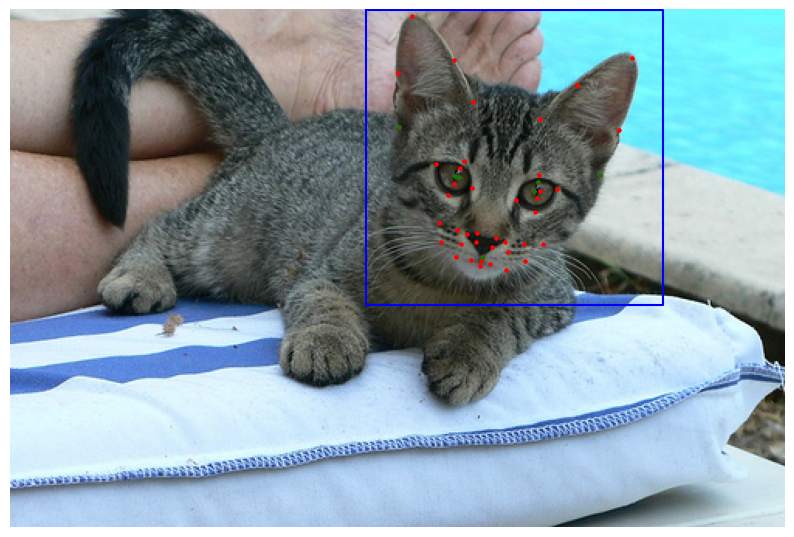

In [126]:
# Display the image with corresponding bounding box and landmark coordinates
import matplotlib.pyplot as plt

# Choose a random image
idx = np.random.randint(0, len(images))

# Get the image, landmarks, and bounding box
image = images[idx]
#temp_landmarks = labels[idx]
landmarks = labels[idx]
bbox = bboxes[idx]

# Create a figure and plot the image
plt.figure(figsize=(10, 10))
plt.imshow(image)

# Plot the landmarks
plt.scatter(landmarks[:, 0], landmarks[:, 1], s=5, c='red')
plt.scatter(landmarks[[36,37,39,40,22,31,16], 0], landmarks[[36,37,39,40,22,31,16], 1], s=5, c='green')

# Plot the bounding box
plt.plot([bbox[0], bbox[0], bbox[2], bbox[2], bbox[0]],
         [bbox[1], bbox[3], bbox[3], bbox[1], bbox[1]],
         c='blue')

plt.axis('off')
# Show the plot
plt.show()

# Load Data

In [55]:
# Not run
# Original data from manully curated images
'''
import pandas as pd

# Load the CSV file
file_path = '/content/cat-facial-expression-recognition/landmark_all2.csv'
df = pd.read_csv(file_path)

# Combine landmark, vector_x, and vector_y into a single identifier
df['landmark_vector_x'] = df.apply(lambda row: f"{row['landmark']}_x", axis=1)
df['landmark_vector_y'] = df.apply(lambda row: f"{row['landmark']}_y", axis=1)

# Concatenate the two pivot tables
df_wide = df.pivot_table(index=['filename', 'class', 'image_path'],
                         columns='landmark',
                         values=['vector_x', 'vector_y'],
                         aggfunc='first')

df_wide.columns = ['{}_{}'.format(col[0], col[1]) for col in df_wide.columns.values]

# Reset the index to turn the filename back into a column
df_wide.reset_index(inplace=True)
df_wide.drop(columns=['filename'], inplace=True)
df_wide = df_wide[~df_wide['class'].str.contains('neutral', case=False, na=False)]
df_wide = df_wide.reset_index(drop=True)
# Save the transformed dataframe to a new CSV file
#output_file_path = 'path/to/vector_data_wide.csv'
#df_wide.to_csv(output_file_path, index=False)
'''

In [ ]:
'''
# Standardize landmarks

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

columns_to_scale = df_wide.columns[2:]  # All columns except the first and second
columns_untouched = df_wide.columns[:2]  # First and second columns

# Fit and transform the data
scaled_data = scaler.fit_transform(df_wide[columns_to_scale])

df_scaled = pd.DataFrame(scaled_data, columns=columns_to_scale)

# Concatenate the untouched columns with the scaled columns
df_final = pd.concat([df_wide[columns_untouched], df_scaled], axis=1)

print(df_final)
'''

       class                                         image_path  vector_x_0  \
0        sad  /content/cat-facial-expression-recognition/Ima...   -0.301768   
1        sad  /content/cat-facial-expression-recognition/Ima...   -0.301768   
2        sad  /content/cat-facial-expression-recognition/Ima...    0.255665   
3        sad  /content/cat-facial-expression-recognition/Ima...    0.255665   
4        sad  /content/cat-facial-expression-recognition/Ima...    0.255665   
..       ...                                                ...         ...   
261    angry  /content/cat-facial-expression-recognition/Ima...    0.813097   
262      sad  /content/cat-facial-expression-recognition/Ima...   -0.301768   
263  purring  /content/cat-facial-expression-recognition/Ima...    0.255665   
264    angry  /content/cat-facial-expression-recognition/Ima...    1.370530   
265      sad  /content/cat-facial-expression-recognition/Ima...   -0.859201   

     vector_x_1  vector_x_2  vector_x_3  vector_x_4

# Data Loading and Augmentation

In [57]:
'''
# Original data loading

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from PIL import Image
import os

# Load landmarks and labels
landmarks_df = df_wide
image_paths = landmarks_df['image_path'].values
landmarks = landmarks_df.drop(columns=['image_path','class']).values

# Example labels (You should replace this with your actual labels)
labels = landmarks_df['class'].values

# Create label mapping
label_to_int = {label: idx for idx, label in enumerate(np.unique(labels))}
int_to_label = {idx: label for label, idx in label_to_int.items()}

# Convert string labels to integer labels
integer_labels = np.array([label_to_int[label] for label in labels])
'''

In [127]:
# CatFLW data loading

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from PIL import Image
import os

# Load landmarks and labels
landmarks_df = vector_df
image_paths = landmarks_df['file_path'].values
landmarks = landmarks_df.drop(columns=['file_path','image_file','Class','bounding_box']).values

# Example labels (You should replace this with your actual labels)
labels = landmarks_df['Class'].values

# Create label mapping
label_to_int = {label: idx for idx, label in enumerate(np.unique(labels))}
int_to_label = {idx: label for label, idx in label_to_int.items()}

# Convert string labels to integer labels
integer_labels = np.array([label_to_int[label] for label in labels])

In [128]:
# Check Label Shape and Labels
print(labels.shape, landmarks.shape)
print(labels)

(137,) (137, 96)
['Relaxed' 'Relaxed' 'Relaxed' 'Attentive' 'Attentive' 'Attentive'
 'Attentive' 'Relaxed' 'Attentive' 'Attentive' 'Attentive' 'Relaxed'
 'Attentive' 'Relaxed' 'Relaxed' 'Attentive' 'Relaxed' 'Relaxed' 'Relaxed'
 'Attentive' 'Relaxed' 'Relaxed' 'Attentive' 'Relaxed' 'Attentive'
 'Relaxed' 'Attentive' 'Relaxed' 'Relaxed' 'Attentive' 'Relaxed'
 'Attentive' 'Attentive' 'Relaxed' 'Attentive' 'Relaxed' 'Relaxed'
 'Attentive' 'Relaxed' 'Relaxed' 'Relaxed' 'Attentive' 'Attentive'
 'Relaxed' 'Attentive' 'Attentive' 'Attentive' 'Attentive' 'Attentive'
 'Attentive' 'Relaxed' 'Relaxed' 'Attentive' 'Attentive' 'Relaxed'
 'Attentive' 'Attentive' 'Attentive' 'Attentive' 'Relaxed' 'Relaxed'
 'Attentive' 'Attentive' 'Relaxed' 'Relaxed' 'Relaxed' 'Attentive'
 'Relaxed' 'Attentive' 'Attentive' 'Relaxed' 'Relaxed' 'Relaxed'
 'Attentive' 'Attentive' 'Attentive' 'Attentive' 'Attentive' 'Relaxed'
 'Attentive' 'Attentive' 'Attentive' 'Relaxed' 'Attentive' 'Attentive'
 'Attentive' 'Attentive' 

In [129]:
# Image processing with bounding box cropping and conversion to grayscale (with backward conversion for pre-trained image model)

def load_and_preprocess_image(image_path, bounding_box, target_size=(150, 150)):
    try:
        # Open the image
        img = Image.open(image_path)

        # Crop the image using the bounding box coordinates
        x_min, y_min, x_max, y_max = bounding_box
        img = img.crop((x_min, y_min, x_max, y_max))

        # Resize the image
        img = img.resize(target_size)

        # Convert image to grayscale
        img = img.convert('L')  # 'L' mode is for grayscale

        # Convert image to numpy array and ensure it's in uint8 format
        img_array = np.array(img, dtype=np.uint8)

        # If the image is grayscale, convert it to RGB
        if len(img_array.shape) == 2 or (len(img_array.shape) == 3 and img_array.shape[2] == 1):
            img_array = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)

        # Normalize the image
        img_array = img_array / 255.0

        return img_array
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

# Load and preprocess images
target_size = (224, 224)
images = [load_and_preprocess_image(row['file_path'], row['bounding_box'], target_size=target_size) for _, row in filtered_df.iterrows()]

In [59]:
'''
def load_and_preprocess_image(image_path, target_size=(150, 150)):
    try:
        # Open and resize the image
        img = Image.open(image_path)
        img = img.resize(target_size)

        # Convert image to numpy array and ensure it's in uint8 format
        img_array = np.array(img, dtype=np.uint8)

        # Convert image to grayscale
        img = img.convert('L')  # 'L' mode is for grayscale

        # If the image is grayscale, convert it to RGB
        if len(img_array.shape) == 2 or (len(img_array.shape) == 3 and img_array.shape[2] == 1):
            img_array = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)

        # Normalize the image
        img_array = img_array / 255.0

        filename = image_path
        return img_array
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

# Load and preprocess images
target_size = (224,224)
images = ([load_and_preprocess_image(img_path, target_size=target_size) for img_path in image_paths])
'''

In [130]:
# Check image array shapes (Should be (_ , 224, 224, 3))
np.shape(images)

(137, 224, 224, 3)

In [131]:
# Check if grayscale images are processed correctly (Should not print anything)
for img in images:
  if len(img.shape) == 2:
    print(img.shape)

In [132]:
# Train-test split with stratification
X_train_images, X_val_images, X_train_landmarks, X_val_landmarks, y_train, y_val = train_test_split(
    images, landmarks, integer_labels,
    test_size=0.3,
    random_state=22,
    stratify=integer_labels  # Ensure stratification based on labels
)

In [133]:
# Check number of samples for each class to confirm correct stratification

import numpy as np
from collections import Counter

# Count occurrences of each class in the training set
train_class_counts = Counter(y_train)
print("Number of samples per class in training set:")
for class_label, count in train_class_counts.items():
    print(f"Class {class_label}: {count} samples")

# Count occurrences of each class in the validation set
val_class_counts = Counter(y_val)
print("\nNumber of samples per class in validation set:")
for class_label, count in val_class_counts.items():
    print(f"Class {class_label}: {count} samples")

Number of samples per class in training set:
Class 1: 38 samples
Class 0: 57 samples

Number of samples per class in validation set:
Class 0: 25 samples
Class 1: 17 samples


In [134]:
# Convert labels to categorical
num_classes = len(np.unique(labels))
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)

In [135]:
print(num_classes, y_val[0])

2 [1. 0.]


In [136]:
# Augement images and landmarks together

import tensorflow as tf
import albumentations as A
import numpy as np
from PIL import Image

def add_noise_to_landmarks(landmarks, noise_level=1e-5):
    """
    Add Gaussian noise to landmarks.

    Args:
    - landmarks (np.ndarray): Array of shape (n_landmarks, 2) containing landmark coordinates.
    - noise_level (float): Standard deviation of Gaussian noise to be added.

    Returns:
    - np.ndarray: Landmarks with added noise.
    """
    noise = np.random.normal(scale=noise_level, size=landmarks.shape)
    noisy_landmarks = landmarks + noise
    return noisy_landmarks

def augment_image(image):
    """
    Augment the image without altering the landmarks.

    Args:
    - image (np.ndarray): The image to be augmented.

    Returns:
    - np.ndarray: Augmented image.
    """
    transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        #A.RandomRotate90(p=0.5),
        A.ColorJitter(p=0.3),
        A.RandomBrightnessContrast(p=0.3),
        #A.Rotate(p=0.8)
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=20, p=0.9)
    ])

    # Ensure image is in uint8 format
    image = (image * 255).astype(np.uint8)

    # Apply the transformations
    augmented = transform(image=image)
    augmented_image = augmented['image']

    return augmented_image

# Function to augment data
def augment_data(images, landmarks, augmentations_per_image=5, noise_level=1e-4):
    augmented_images = []
    augmented_landmarks = []
    for img, lnd in zip(images, landmarks):
        for _ in range(augmentations_per_image):
            aug_img = augment_image(img)
            noisy_lnd = add_noise_to_landmarks(lnd.reshape(-1, 2), noise_level).flatten()
            augmented_images.append(aug_img)
            augmented_landmarks.append(noisy_lnd)
    return np.array(augmented_images), np.array(augmented_landmarks)

# Apply augmentations to the training data
augmentations_per_image = 5  # Number of augmentations per image
augmented_X_train_images, augmented_X_train_landmarks = augment_data(X_train_images, X_train_landmarks, augmentations_per_image)

# Repeat labels to match the number of augmented images
y_train_repeated = np.repeat(y_train, augmentations_per_image, axis=0)

# Create a tf.data.Dataset
def create_dataset(images, landmarks, labels, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(((images, landmarks), labels))
    dataset = dataset.shuffle(buffer_size=len(images)).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

batch_size = 32

train_dataset = create_dataset(augmented_X_train_images, augmented_X_train_landmarks, y_train_repeated, batch_size)
validation_dataset = create_dataset(X_val_images, X_val_landmarks, y_val, batch_size)

In [137]:
augmented_X_train_images.shape ,y_train_repeated.shape

((475, 224, 224, 3), (475, 2))

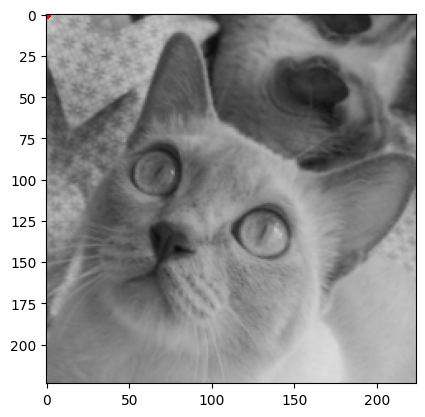

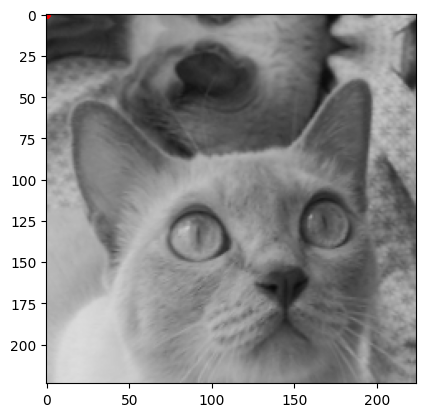

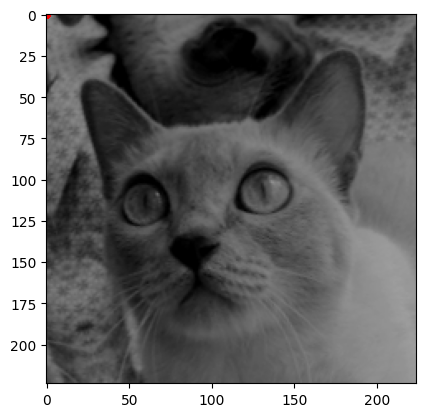

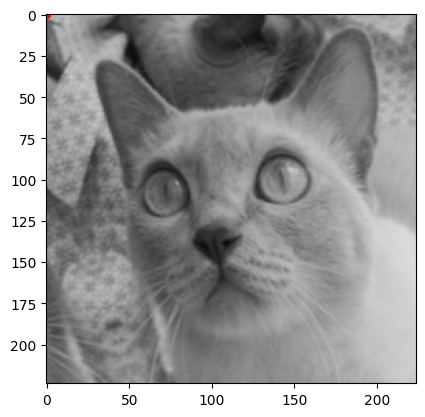

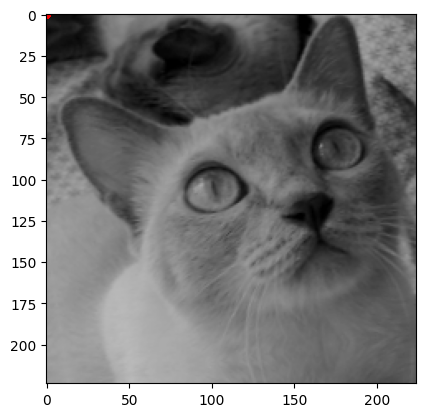

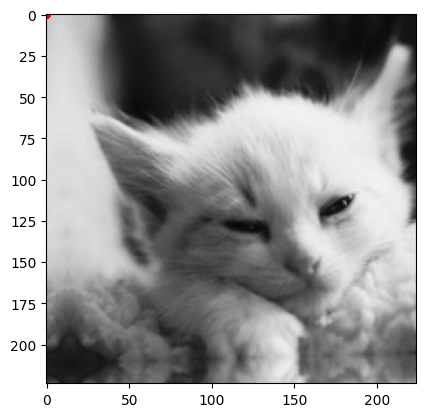

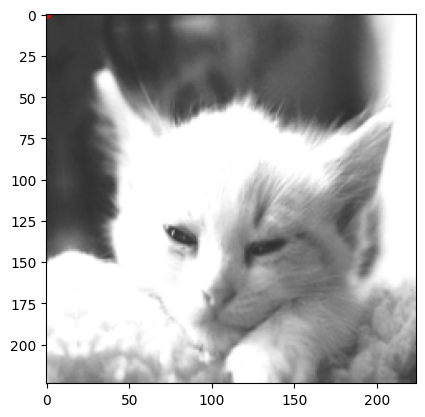

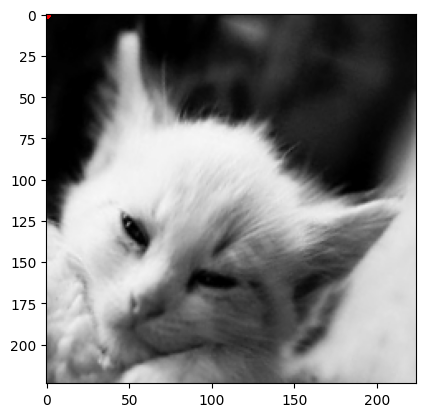

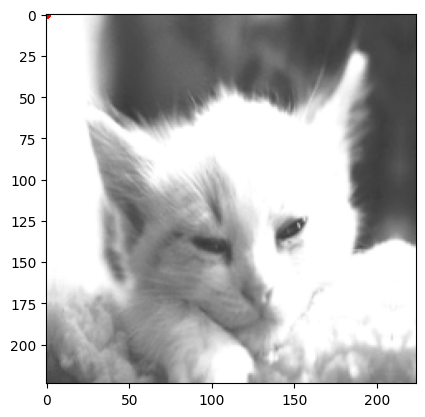

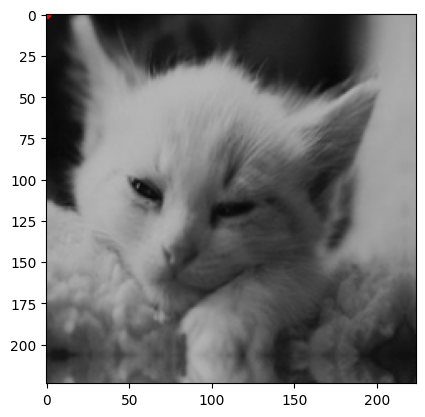

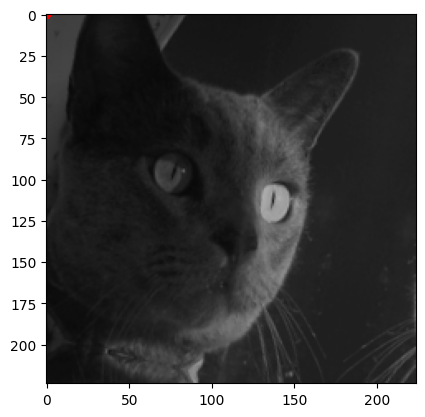

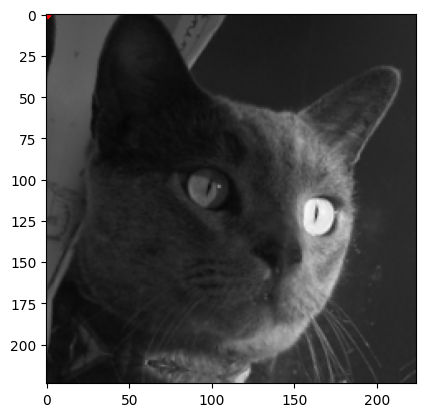

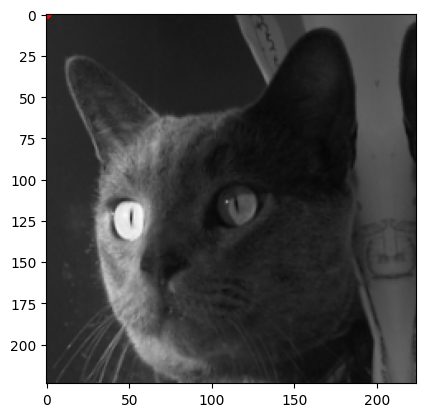

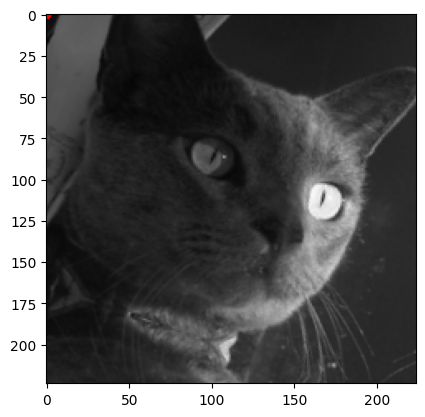

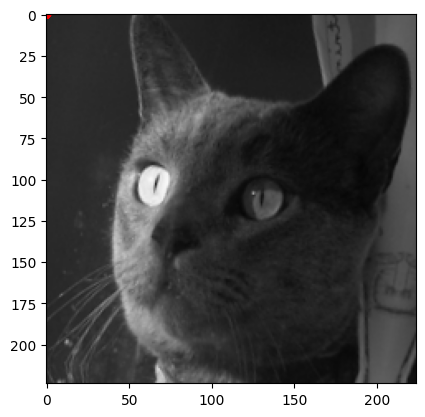

In [138]:
# Display augmented images
import matplotlib.pyplot as plt

def plot_image_with_landmarks(image, landmarks):
    """
    Plots an image with landmarks overlaid.

    Args:
    - image (np.ndarray): The image to plot.
    - landmarks (np.ndarray): Array of shape (n_landmarks, 2) containing landmark coordinates.
    """
    plt.imshow(image)
    for (x, y) in landmarks.reshape(-1, 2):
        plt.scatter(x, y, c='red', s=10)
    plt.show()

    # Display the augmented image with landmarks

for i in range(100,115):
  plot_image_with_landmarks(augmented_X_train_images[i], augmented_X_train_landmarks[i])

#Create and Train the Multimodal Model

In [139]:
# Choose Base Model and other parameters

from tensorflow.keras.layers import Input
from tensorflow.keras.losses import CategoricalFocalCrossentropy, CategoricalCrossentropy, binary_crossentropy

image_input = Input(shape=(224, 224, 3))
base_model = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_tensor=image_input)
num_epochs = 20
learning_rate = 1e-2
selected_loss = tf.keras.losses.CategoricalCrossentropy()

# Landmark-Only MLP

Epoch 1/300


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.5767 - loss: 14.3193 - val_accuracy: 0.6207 - val_loss: 13.8411
Epoch 2/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6001 - loss: 13.7601 - val_accuracy: 0.6207 - val_loss: 13.3012
Epoch 3/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5808 - loss: 13.2288 - val_accuracy: 0.6207 - val_loss: 12.7795
Epoch 4/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6001 - loss: 12.6951 - val_accuracy: 0.6207 - val_loss: 12.2741
Epoch 5/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6001 - loss: 12.2079 - val_accuracy: 0.6207 - val_loss: 11.7820
Epoch 6/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6001 - loss: 11.7270 - val_accuracy: 0.6207 - val_loss: 11.3028
Epoch 7/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6001 - loss: 11.2462 - val_accuracy: 0.6207 - val_loss: 10.8358
Epoch 8/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6194 - loss: 10.7645 - val_accuracy: 0.6207 - val_l

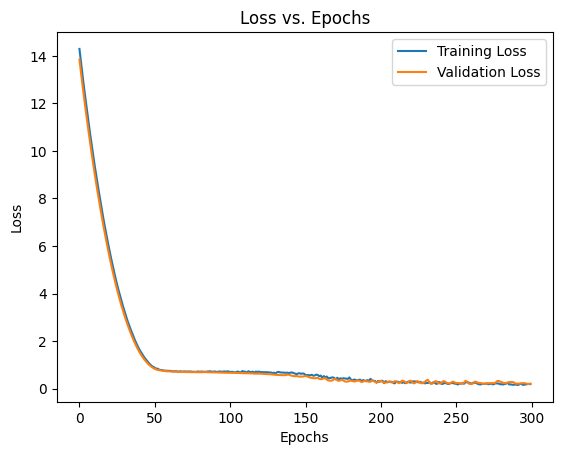

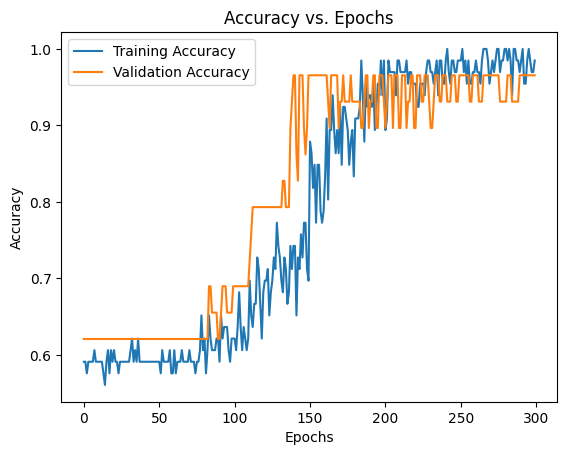

In [140]:
# This is the code to train from extracted landmarks

# Set fixed seeding values for reproducability during experiments

#np.random.seed(2233)
#tf.random.set_seed(3031)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l1_l2
from sklearn.preprocessing import Normalizer, LabelEncoder
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l1_l2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Build the model with L1 and L2 regularization
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_landmarks.shape[1],)),  # Apply L1 and L2 regularization
    Dropout(0.5),  # Dropout layer
    Dense(128, activation='relu',
    kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),  # Apply L1 and L2 regularization
    Dropout(0.5),  # Dropout layer
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model and save the history
history = model.fit(X_train_landmarks, y_train, epochs=300, batch_size=32, validation_split=0.3)
# history = model.fit(augmented_X_train_landmarks, y_train_repeated, epochs=200, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_val_landmarks, y_val)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Plotting the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        25
           1       0.94      1.00      0.97        17

    accuracy                           0.98        42
   macro avg       0.97      0.98      0.98        42
weighted avg       0.98      0.98      0.98        42



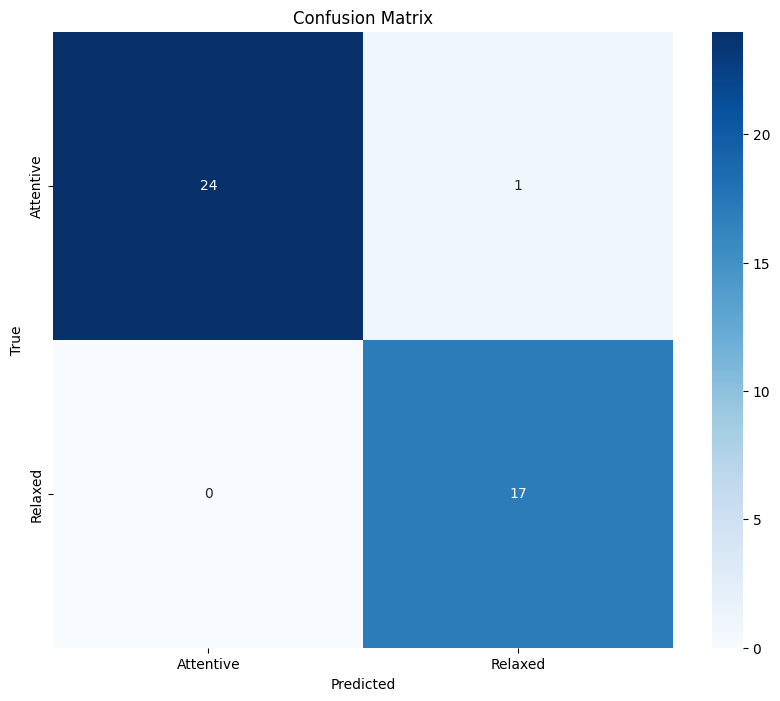

In [141]:
# Classification Report and Confusion Matrix

import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions on the validation dataset
val_predictions = model.predict(X_val_landmarks)

# Convert predictions and true labels to class labels
val_predictions_classes = np.argmax(val_predictions, axis=1)
val_true_classes = np.argmax(y_val, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(val_true_classes, val_predictions_classes)

# Print classification report
print(classification_report(val_true_classes, val_predictions_classes))


# Create a dictionary mapping class names to integer labels
unique_integers = set(integer_labels)
labels_from_int = np.array([int_to_label[integer] for integer in unique_integers])
class_names = dict(zip(labels_from_int, unique_integers))

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 330ms/step - accuracy: 0.3574 - loss: 4.5740 - val_accuracy: 0.2917 - val_loss: 4.1841
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3850 - loss: 4.3937 - val_accuracy: 0.3333 - val_loss: 4.0633
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4025 - loss: 4.1682 - val_accuracy: 0.2917 - val_loss: 3.9445
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3896 - loss: 4.0398 - val_accuracy: 0.2917 - val_loss: 3.8465
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3676 - loss: 3.9608 - val_accuracy: 0.2917 - val_loss: 3.7559
Epoch 6/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4237 - loss: 3.8907 - val_accuracy: 0.3125 - val_loss: 3.6717
Epoch 7/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4318 - loss: 3.8543 - val_accuracy: 0.3125 - val_loss: 3.6054
Epoch 8/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4519 - loss: 3.6546 - val_accuracy: 0.3333 - val_loss: 3.5343
Epoch 9/20

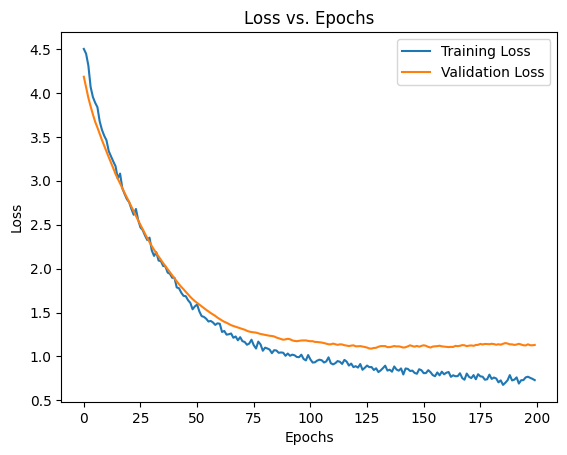

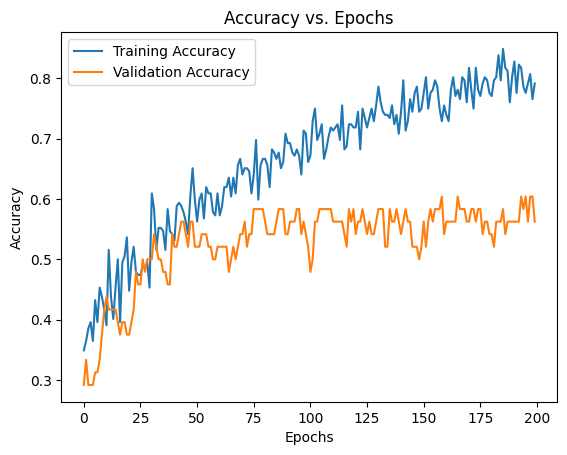

In [ ]:
'''
# Original code from Boss

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l1_l2
from sklearn.preprocessing import Normalizer, LabelEncoder
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l1_l2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

#data = pd.read_csv('Cat_database_3class.csv')
# Separate features and target
X = df_final.drop(columns=['class', 'image_path'])
y = df_final['class']

# Encode the target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# One-hot encode the target
y_categorical = to_categorical(y_encoded)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42
                                                    #,stratify=y_categorical
                                                    )

# Standardize the feature data
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

# Build the model with L1 and L2 regularization
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),  # Apply L1 and L2 regularization
    Dropout(0.5),  # Dropout layer
    Dense(32, activation='relu',
    kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),  # Apply L1 and L2 regularization
    Dropout(0.5),  # Dropout layer
    Dense(y_categorical.shape[1], activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model and save the history
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Plotting the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
'''

# Image-Only Model

In [143]:
# Set up model using base pre-trained model

from tensorflow.keras import layers, models
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, concatenate, GlobalAveragePooling2D, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.optimizers import Adam

# Add custom layers
# num_custom_classes = 3
x = base_model.output
#x = MaxPooling2D((1, 1))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x)  # Replace with your number of classes

# Create the model
image_model = Model(inputs=[image_input], outputs=x)

# If trainable is True, we can set train the layers after last_layer_to_freeze
freeze_model = True
last_layer_to_freeze = 426

if freeze_model == True:
  base_model.trainable = False

elif freeze_model == True:
  for layer in base_model.layers[:last_layer_to_freeze]:
    layer.trainable = False
  for layer in base_model.layers[last_layer_to_freeze:]:
    layer.trainable = True

# Compile the model
image_model.compile(
                      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      loss='categorical_crossentropy',
                      metrics=['accuracy']
                      )

# Callback to save models and weights
save_weights_only = False
save_dir = '/content/cat-facial-image-recognition/saved_model/'

if save_weights_only:
  checkpoint_filepath = save_dir + base_model.name + "bestmodel_epoch{epoch:03d}_valloss{val_loss:.2f}.weights.h5"
else:
  checkpoint_filepath = save_dir + base_model.name + "bestmodel_epoch{epoch:03d}_valloss{val_loss:.2f}.keras"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint( filepath=checkpoint_filepath,
                                                                save_weights_only=save_weights_only,
                                                                monitor='val_loss',
                                                                mode='min',
                                                                verbose = 1,
                                                                save_best_only=True )

In [144]:
# Section to create image-only dataset for comparison
def create_image_only_dataset(images, labels, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.shuffle(buffer_size=len(images)).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

# Augment the images without altering landmarks for image-only dataset
augmented_X_train_images_only = []
for img in X_train_images:
    for _ in range(augmentations_per_image):
        aug_img = augment_image(img)
        augmented_X_train_images_only.append(aug_img)
augmented_X_train_images_only = np.array(augmented_X_train_images_only)

# Repeat labels to match the number of augmented images for image-only dataset
y_train_repeated_images_only = np.repeat(y_train, augmentations_per_image, axis=0)

# Create image-only dataset
image_only_train_dataset = create_image_only_dataset(augmented_X_train_images_only, y_train_repeated_images_only, batch_size)
image_only_validation_dataset = create_image_only_dataset(X_val_images, y_val, batch_size)

In [145]:
augmented_X_train_images_only.shape, y_train_repeated_images_only.shape, y_val.shape, num_classes

((475, 224, 224, 3), (475, 2), (42, 2), 2)

In [146]:
history_image_only = image_model.fit(
    image_only_train_dataset,
    #steps_per_epoch=train_dataset.samples // train_dataset.batch_size,
    validation_data=image_only_validation_dataset,
    #validation_steps=validation_dataset.samples // validation_dataset.batch_size,
    epochs=num_epochs,
    #callbacks=[model_checkpoint_callback, wandb_callback]
)

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 94s 6s/step - accuracy: 0.4956 - loss: 19774.2109 - val_accuracy: 0.5952 - val_loss: 1.6393
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 79s 5s/step - accuracy: 0.5496 - loss: 196.1519 - val_accuracy: 0.4048 - val_loss: 1.3200
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 82s 6s/step - accuracy: 0.5638 - loss: 58.7451 - val_accuracy: 0.4048 - val_loss: 0.7799
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 82s 5s/step - accuracy: 0.5848 - loss: 21.3032 - val_accuracy: 0.3810 - val_loss: 0.8253
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 81s 5s/step - accuracy: 0.7503 - loss: 7.2831 - val_accuracy: 0.4286 - val_loss: 0.8542
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 77s 5s/step - accuracy: 0.7950 - loss: 4.4492 - val_accuracy: 0.4048 - val_loss: 0.8619
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 79s 5s/step - accuracy: 0.7212 - loss: 7.1282 - val_accuracy: 0.4048 - val_loss: 0.8523
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 79s 5s/step - accuracy: 0.8188 - loss: 5.1530 - val_accuracy: 0.4286 - v

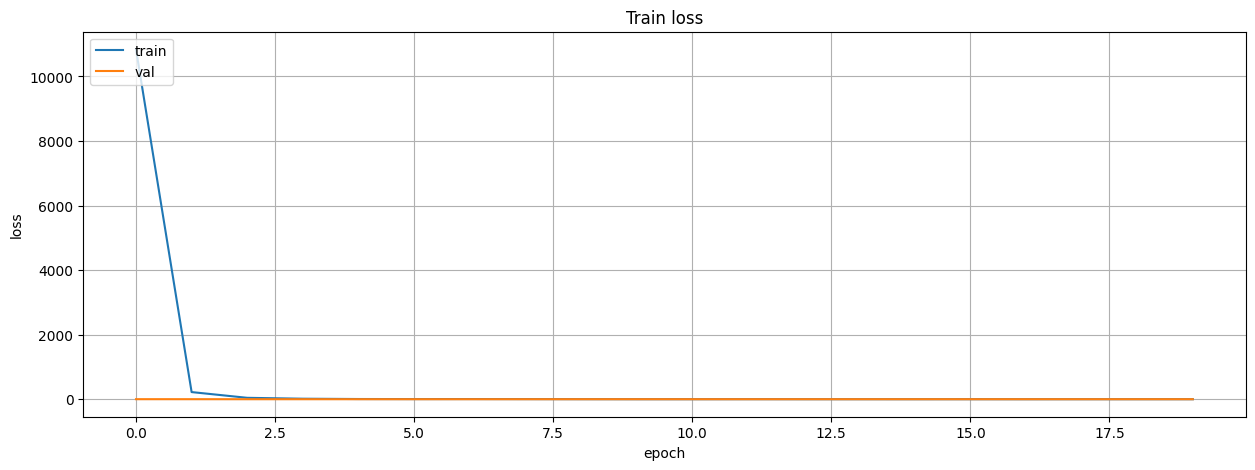

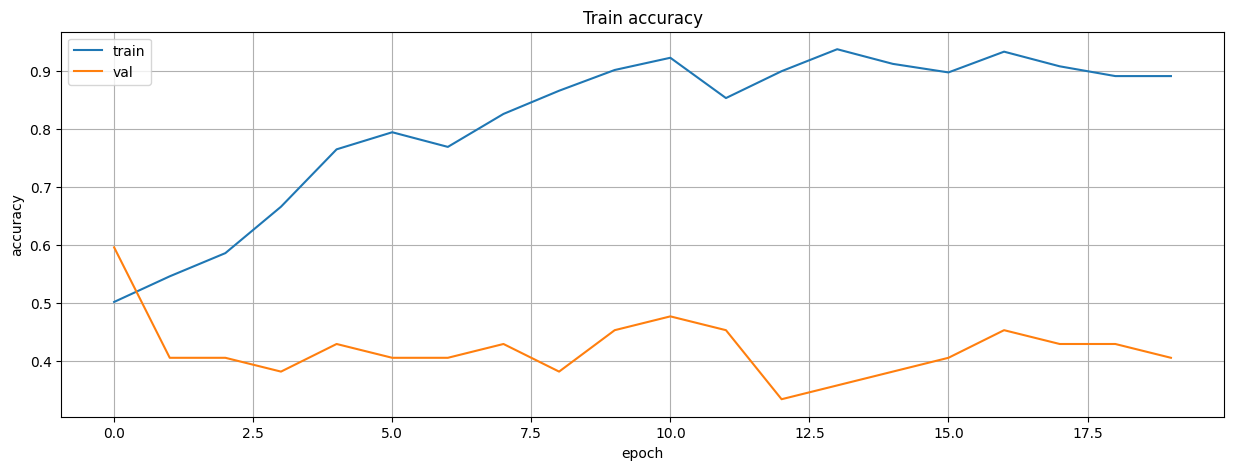

In [150]:
# Summarize history for loss
plt.figure(figsize=(15,5))
plt.plot(history_image_only.history['loss'])
plt.plot(history_image_only.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

# Summarize history for accuracy
plt.figure(figsize=(15,5))
plt.plot(history_image_only.history['accuracy'])
plt.plot(history_image_only.history['val_accuracy'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step
              precision    recall  f1-score   support

           0       1.00      0.08      0.15        25
           1       0.42      1.00      0.60        17

    accuracy                           0.45        42
   macro avg       0.71      0.54      0.37        42
weighted avg       0.77      0.45      0.33        42



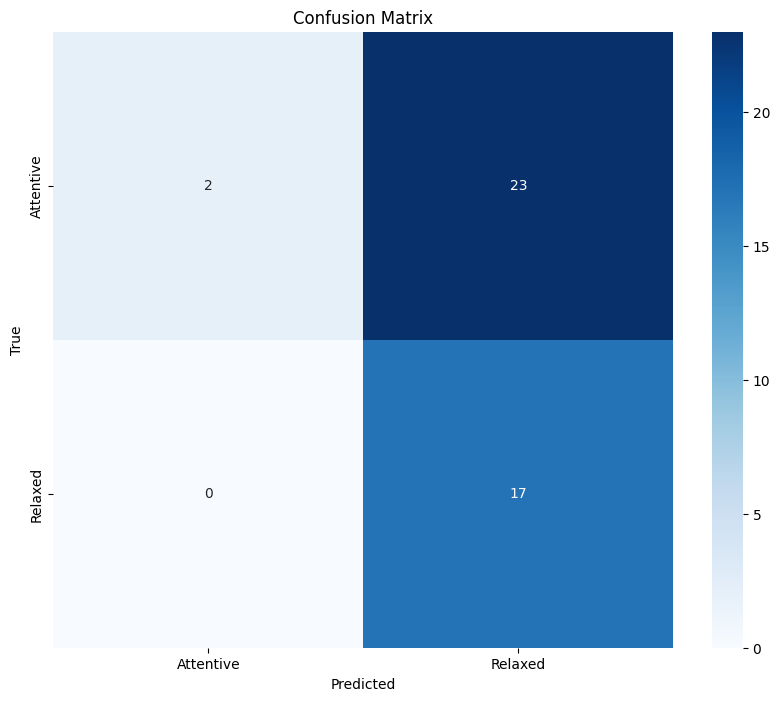

In [148]:
# Classification Report and Confusion Matrix

import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions on the validation dataset
val_predictions = image_model.predict(image_only_validation_dataset)

# Convert predictions and true labels to class labels
val_predictions_classes = np.argmax(val_predictions, axis=1)
val_true_classes = np.argmax(y_val, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(val_true_classes, val_predictions_classes)

# Print classification report
print(classification_report(val_true_classes, val_predictions_classes))

# Create a dictionary mapping class names to integer labels
unique_integers = set(integer_labels)
labels_from_int = np.array([int_to_label[integer] for integer in unique_integers])
class_names = dict(zip(labels_from_int, unique_integers))

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Multimodal Model

In [ ]:
from tensorflow.keras import layers, models
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, concatenate, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2

# Add custom layers
# num_custom_classes = 3

x = base_model.output
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Vector input branch
landmark_input = Input(shape=(X_train_landmarks.shape[1],))
y = Dense(128, activation='relu')(landmark_input)
# y = BatchNormalization()(y)
y = Dropout(0.5)(y)
y = Dense(128, activation='relu')(y)

# Concatenate image and vector branches
combined = concatenate([x, y])

# Additional Dense layers after concatenation
z = Dense(256, activation='relu')(combined)
z = BatchNormalization()(z)
z = Dropout(0.5)(z)
z = Dense(128, activation='relu')(z)
z = BatchNormalization()(z)
z = Dropout(0.5)(z)
z = Dense(num_classes, activation='softmax')(z)

# Original custom model
'''x = base_model.output
x = Flatten()(x)
x = BatchNormalization()(x)  # Normalize output of base model

# Landmark input branch
landmark_input = Input(shape=(X_train_landmarks.shape[1],))
y = Dense(128, activation='relu')(landmark_input)
y = Dropout(0.5)(y)
y = Dense(128, activation='relu',
    kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(y)
y = Dropout(0.5)(y)
y = Dense(128, activation='relu')(y)

# Combine the outputs from the two branches
combined = concatenate([x, y])

# Add a few more layers
z = Dense(256, activation='relu')(combined)
z = Dropout(0.5)(z)
# z = Dense(64, activation='relu')(z)  # Apply L1 and L2 regularization
# z = Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(z)
# z = Dropout(0.5)(z)
z = Dense(num_classes, activation='softmax')(z)'''

# Create the model
current_model = Model(inputs=[image_input, landmark_input], outputs=z)

# If trainable is True, we can set train the layers after last_layer_to_freeze
freeze_model = True
last_layer_to_freeze = 426

if freeze_model == True:
  base_model.trainable = False

elif freeze_model == True:
  for layer in base_model.layers[:last_layer_to_freeze]:
    layer.trainable = False
  for layer in base_model.layers[last_layer_to_freeze:]:
    layer.trainable = True

# Compile the model
current_model.compile(
                      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      loss=selected_loss,
                      metrics=['accuracy']
                      )

# Callback to save models and weights
save_weights_only = False
save_dir = '/content/cat-facial-image-recognition/saved_model/'

if save_weights_only:
  checkpoint_filepath = save_dir + base_model.name + "bestmodel_epoch{epoch:03d}_valloss{val_loss:.2f}.weights.h5"
else:
  checkpoint_filepath = save_dir + base_model.name + "bestmodel_epoch{epoch:03d}_valloss{val_loss:.2f}.keras"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint( filepath=checkpoint_filepath,
                                                                save_weights_only=save_weights_only,
                                                                monitor='val_loss',
                                                                mode='min',
                                                                verbose = 1,
                                                                save_best_only=True )

In [ ]:
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

history = current_model.fit(
    train_dataset,
    #steps_per_epoch=train_dataset.samples // train_dataset.batch_size,
    validation_data=validation_dataset,
    #validation_steps=validation_dataset.samples // validation_dataset.batch_size,
    epochs=num_epochs,
    # callbacks=[clr]
    #callbacks=[model_checkpoint_callback, wandb_callback]
)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.3401 - loss: 2.4792 - val_accuracy: 0.5054 - val_loss: 7.0245
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5992 - loss: 1.1818 - val_accuracy: 0.5054 - val_loss: 7.3914
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5938 - loss: 1.1937 - val_accuracy: 0.5054 - val_loss: 1.4724
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6357 - loss: 1.0139 - val_accuracy: 0.5054 - val_loss: 1.8157
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6474 - loss: 0.9786 - val_accuracy: 0.5054 - val_loss: 1.3352
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6262 - loss: 0.9652 - val_accuracy: 0.5054 - val_loss: 1.5517
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7098 - loss: 0.9003 - val_accuracy: 0.5054 - val_loss: 2.0004
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7246 - loss: 0.7585 - val_accuracy: 0.5054 - va

6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step
              precision    recall  f1-score   support

           0       0.51      1.00      0.68        47
           1       0.00      0.00      0.00         4
           2       1.00      0.03      0.06        31
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         6

    accuracy                           0.52        93
   macro avg       0.30      0.21      0.15        93
weighted avg       0.59      0.52      0.36        93



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


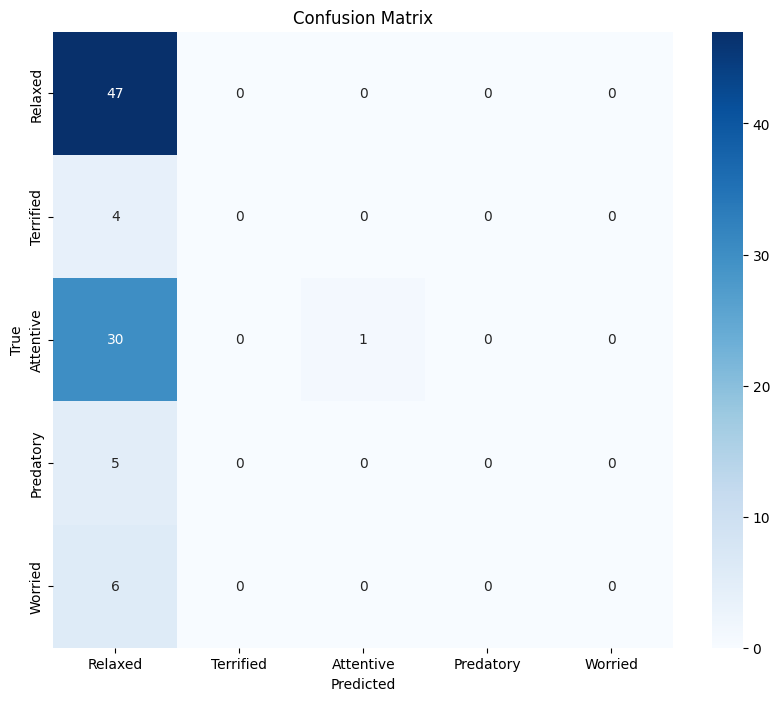

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions on the validation dataset
val_predictions = current_model.predict(validation_dataset)

# Convert predictions and true labels to class labels
val_predictions_classes = np.argmax(val_predictions, axis=1)
val_true_classes = np.argmax(y_val, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(val_true_classes, val_predictions_classes)

# Print classification report
print(classification_report(val_true_classes, val_predictions_classes))


# Create a dictionary mapping class names to integer labels
unique_integers = set(integer_labels)
labels_from_int = np.array([int_to_label[integer] for integer in unique_integers])
class_names = dict(zip(labels_from_int, unique_integers))


# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


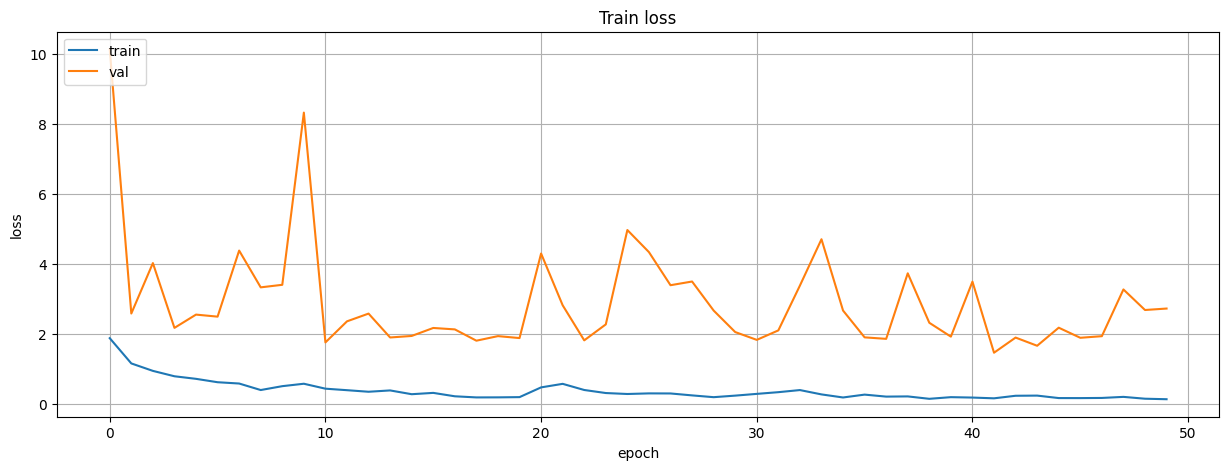

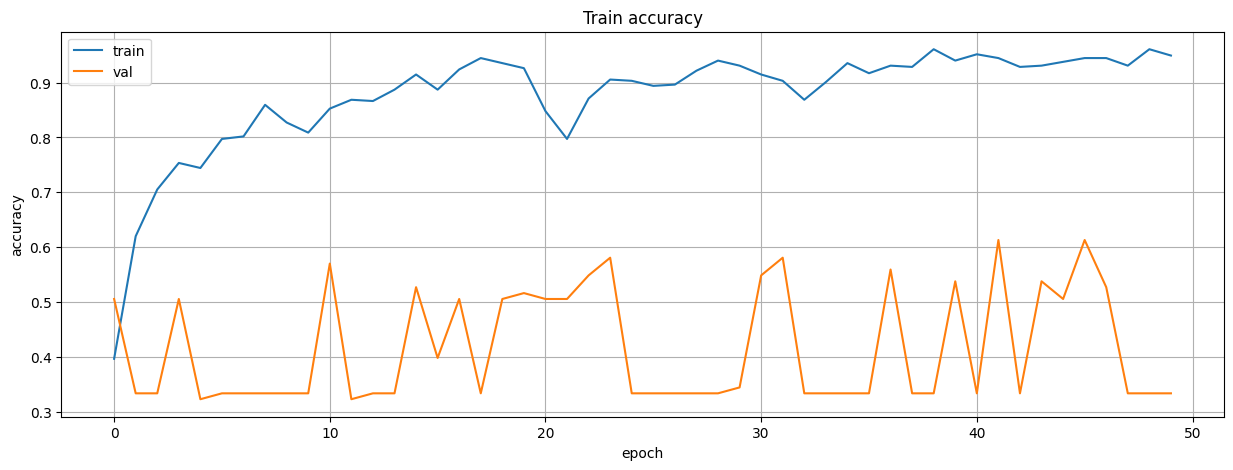

In [ ]:
# Summarize history for loss
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

# Summarize history for accuracy
plt.figure(figsize=(15,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

In [ ]:
# Set up wandb

from wandb.integration.keras import WandbCallback

!wandb login 872265a615a7284a38f47af24b872eaee0dfcfa6

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="Cat Facial Expression Recognition",

    # track hyperparameters and run metadata
    config={
    "learning_rate": learning_rate,
    "architecture": base_model.name,
    "dataset": "custom",
    "epochs": num_epochs,
    }
)

# Set wandb callback
wandb_callback = WandbCallback(
    monitor="val_loss", verbose=0, mode="auto", save_weights_only=(False),
    log_weights=(False), log_gradients=(False), save_model=(False),
    training_data=None, validation_data=None, labels=None, predictions=36,
    generator=None, input_type=None, output_type=None, log_evaluation=(False),
    validation_steps=None, class_colors=None, log_batch_frequency=None,
    log_best_prefix="best_", save_graph=(True), validation_indexes=None,
    validation_row_processor=None, prediction_row_processor=None,
    infer_missing_processors=(True), log_evaluation_frequency=0,
    compute_flops=(False)
)

In [ ]:
# Check Model Structure

current_model.summary()
tf.keras.utils.plot_model(current_model,
                          #to_file='cnn1_nonsequential1.png',
                          show_shapes=True, show_dtype=False, show_layer_names=True, dpi=96)

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 56, 56, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 56, 56, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 58, 58, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_preact_r… │
│ (Conv2D)             

 Total params: 49,819,653 (190.05 MB)

 Trainable params: 26,053,125 (99.38 MB)

 Non-trainable params: 23,766,528 (90.66 MB)

# Semi-Supervised